In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score 
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv("infosys.csv")
df = df.drop(["Total Turnover (Rs.)", "No. of Trades", "% Deli. Qty to Traded Qty","Deliverable Quantity", "Spread High-Low", "Spread Close-Open", 'MID_VA'], axis=1)
df.rename(columns={"No.of Shares": "volume"}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df['returns'] = df['Close Price'].pct_change()  # Percentage chang
df.sample(5)

,Date,Open Price,High Price,Low Price,Close Price,WAP,volume,returns
23,2024-12-16,2420.00,2420.0,2387.05,2403.35,2399.051693,48691,0.019751
58,2024-10-24,2990.65,3003.8,2951.05,2971.30,2980.699791,45978,0.004038
190,2024-04-15,2798.00,2852.6,2798.00,2843.55,2834.121513,102680,0.004593
682,2022-04-21,3095.00,3173.5,3090.50,3156.70,3149.808194,69664,-0.002544
341,2023-09-04,3259.55,3265.0,3216.30,3235.20,3231.709964,46439,0.003567


In [3]:
# Black-Scholes Model Function
df["Strike price"] = 1860
df['Volatility'] = 0.2817
df['T'] = 2/12
df['risk free rate'] = 0.07365
def call_option(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = norm.cdf(d1) * S0 - norm.cdf(d2) * K * np.exp(-r * T)  # Call Price
    return call_price
df['Option Price'] = df.apply(lambda row: call_option(row['Close Price'], row['Strike price'], row['T'], row['risk free rate'], row['Volatility']), axis=1)
noise = np.random.normal(0, 0.05, len(df))  # Adding 2% noise
df["Market_Option_Price"] = df["Option Price"] * (1 + noise)


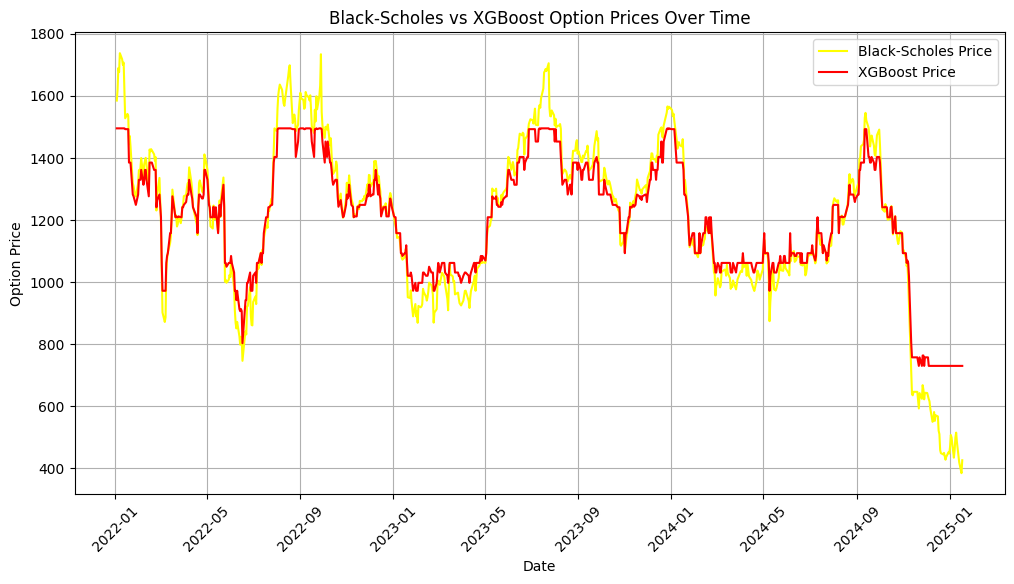

In [4]:
X = df[['Close Price', 'Strike price', 'T', 'Volatility']]
Y = df[['Market_Option_Price']]

# Train/Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=30, reg_lambda=10,learning_rate=0.05, max_depth=3, random_state=42)
xgb_model.fit(X_train, Y_train)
df["XGB_Option_Price"] = xgb_model.predict(X)
df.sort_values("Date", inplace=True)
df_grouped = df.groupby("Date", as_index=False)[["Option Price", "XGB_Option_Price"]].mean()
plt.figure(figsize=(12, 6))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(df_grouped["Date"], df_grouped["Option Price"],label="Black-Scholes Price", color="yellow")
plt.plot(df_grouped["Date"], df_grouped["XGB_Option_Price"], label="XGBoost Price", color="red")
plt.xlabel("Date")
plt.ylabel("Option Price")
plt.title("Black-Scholes vs XGBoost Option Prices Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.show()
